In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os


In [2]:
xray_data = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')
num_obs = len(xray_data)
print('Number of observations:',num_obs)
xray_data.head()

Number of observations: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
from glob import glob

my_glob = glob('/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/*.png')
print('Number of images:', len(my_glob))


Number of images: 112120


In [4]:
# Map the image paths onto xray_data
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)
xray_data.shape

(112120, 13)

In [5]:
dropLabels = ['Image Index', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
xray_data.drop(columns = dropLabels, inplace = True)
xray_data.shape

(112120, 3)

In [6]:
xray_data.head()

,Finding Labels,Patient ID,full_path
0,Cardiomegaly,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
1,Cardiomegaly|Emphysema,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
2,Cardiomegaly|Effusion,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
3,No Finding,2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
4,Hernia,3,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...


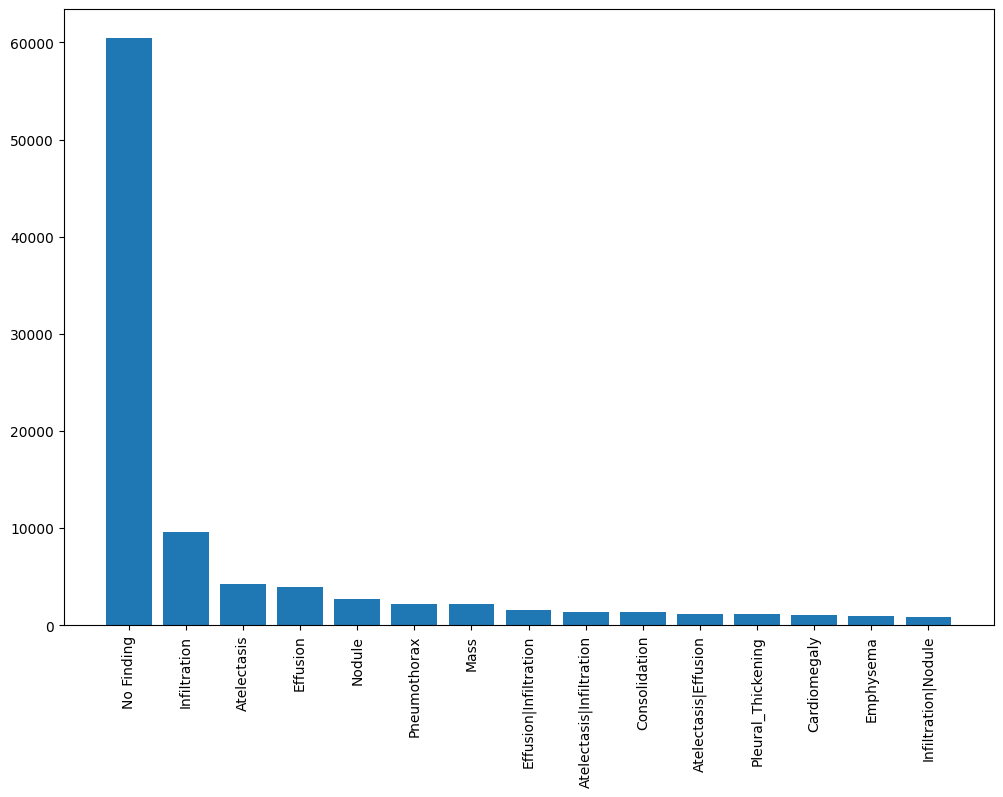

In [7]:
label_counts = xray_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
xray_data.head()

,Finding Labels,Patient ID,full_path
0,Cardiomegaly,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
1,Cardiomegaly|Emphysema,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
2,Cardiomegaly|Effusion,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
3,No Finding,2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
4,Hernia,3,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...


In [9]:
xray_data['Finding Labels'] = xray_data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_data[c_label] = xray_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_data.shape

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


(112120, 17)

In [10]:
# keep at least 1000 cases
MIN_CASES = 0
all_labels = [c_label for c_label in all_labels if xray_data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(xray_data[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 11535), ('Cardiomegaly', 2772), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13307), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19870), ('Mass', 5746), ('Nodule', 6323), ('Pleural_Thickening', 3385), ('Pneumonia', 1353), ('Pneumothorax', 5298)]


In [11]:
# drop up to 10 rows where 'No Finding' equals 1
#to_drop = xray_data[xray_data['No Finding'] == 1].index[:18596]
#xray_data = xray_data.drop(to_drop)

# print the number of rows in the resulting DataFrame
#print(xray_data.shape[0])

In [12]:
hernia_copy=xray_data

In [13]:
"""# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = xray_data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
xray_data = xray_data.sample(50000, weights=sample_weights)

label_counts = xray_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)"""

"# since the dataset is very unbiased, we can resample it to be a more reasonable collection\n# weight is 0.1 + number of findings\nsample_weights = xray_data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2\nsample_weights /= sample_weights.sum()\nxray_data = xray_data.sample(50000, weights=sample_weights)\n\nlabel_counts = xray_data['Finding Labels'].value_counts()[:15]\nfig, ax1 = plt.subplots(1,1,figsize = (12, 8))\nax1.bar(np.arange(len(label_counts))+0.5, label_counts)\nax1.set_xticks(np.arange(len(label_counts))+0.5)\n_ = ax1.set_xticklabels(label_counts.index, rotation = 90)"

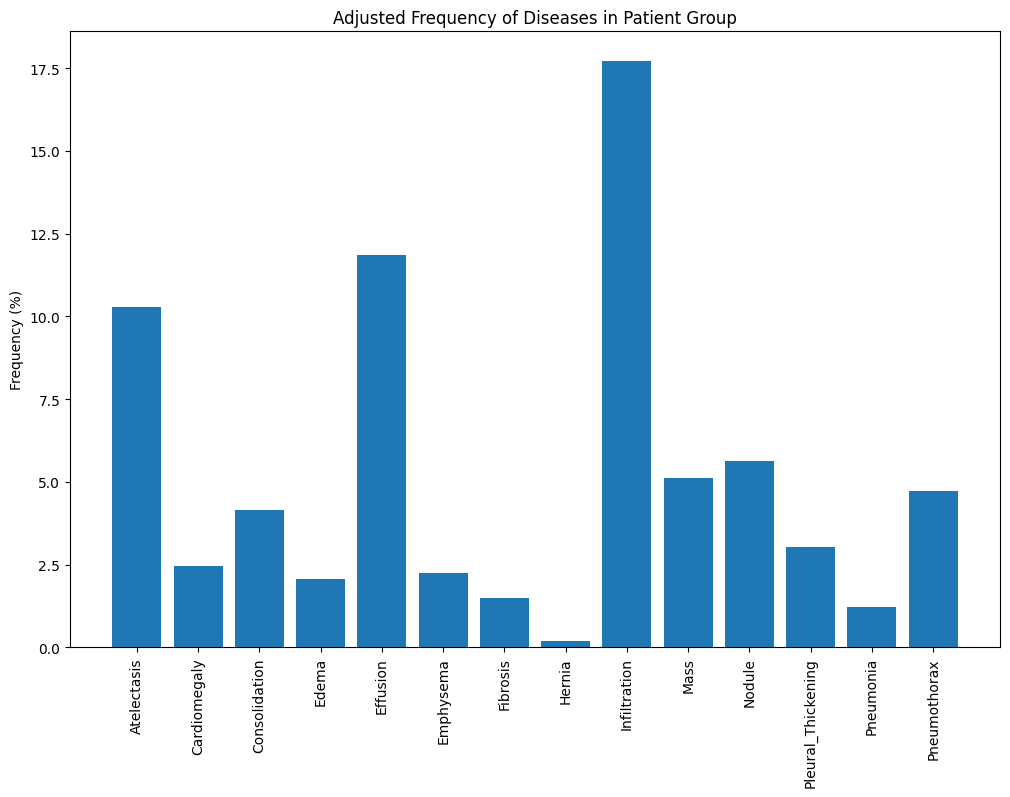

In [14]:
label_counts = 100*np.mean(xray_data[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts) 
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [15]:
# Clean Labels (14) [('Atelectasis', 10709), ('Cardiomegaly', 2565), ('Consolidation', 4409), ('Edema', 2185), ('Effusion', 12407), ('Emphysema', 2349), ('Fibrosis', 1544), ('Hernia', 215), ('Infiltration', 18066), ('Mass', 5345), ('Nodule', 5816), ('Pleural_Thickening', 3157), ('Pneumonia', 1378), ('Pneumothorax', 4904)]


MIN_CASES = 0
all_labels = [c_label for c_label in all_labels if xray_data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(xray_data[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 11535), ('Cardiomegaly', 2772), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13307), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19870), ('Mass', 5746), ('Nodule', 6323), ('Pleural_Thickening', 3385), ('Pneumonia', 1353), ('Pneumothorax', 5298)]


In [16]:
xray_data.shape

(112120, 17)

In [17]:
#xray_data.to_csv('NIH/resampled_data.csv', index=False)
#xray_data.shape

In [18]:
df= xray_data

# Check for duplicates in the 'Patient ID' column
print(any(df['Patient ID'].duplicated()))

# Check for missing values in the 'Patient ID' column
print(df['Patient ID'].isna().sum())

True
0


In [19]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets based on the 'id' column
train_ids, test_ids = train_test_split(df['Patient ID'].unique(), test_size=0.2, random_state=2023)

# Split the train data further into train and validation sets
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=2023)

# Create train, validation, and test dataframes based on the split ids
train_df = df[df['Patient ID'].isin(train_ids)]
val_df = df[df['Patient ID'].isin(val_ids)]
test_df = df[df['Patient ID'].isin(test_ids)]
print(df.shape[0], train_df.shape[0], val_df.shape[0], test_df.shape[0])

112120 79893 8654 23573


In [20]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0 
    return leakage


In [21]:
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(val_df, test_df, 'Patient ID')

False

In [22]:
# print the number of rows in each set
print(f'Train set: {train_df.shape[0]} rows')
print(f'Validation set: {val_df.shape[0]} rows')
print(f'Test set: {test_df.shape[0]} rows')

Train set: 79893 rows
Validation set: 8654 rows
Test set: 23573 rows


In [23]:
# print the number of rows in each set
print('Train set:', train_df['Patient ID'].nunique())
print('Validation set:', val_df['Patient ID'].nunique())
print('Test set:', test_df['Patient ID'].nunique())

Train set: 22179
Validation set: 2465
Test set: 6161


In [24]:
print('train', train_df.shape[0],'vald:',val_df.shape[0], 'test:', test_df.shape[0])

train 79893 vald: 8654 test: 23573


In [25]:

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
val_df.to_csv('validation.csv', index=False)

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model

from keras.optimizers import Adam
from keras.optimizers import AdamW
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Import Densenet from Keras
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

2024-07-28 14:06:32.463104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 14:06:32.463204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 14:06:32.602594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
          'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass','Hernia']

In [28]:
print('train', train_df.shape[0],'vald:',val_df.shape[0], 'test:', test_df.shape[0])

train 79893 vald: 8654 test: 23573


In [29]:
# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(2, 2))
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Apply CLAHE to the image
    #claheimage = clahe.apply(img)
    img = img / 255.0
    img = (img - mean) / std
    return img


horizontal_flip=True, 
    vertical_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.1,
    channel_shift_range=20,
    brightness_range=[0.2, 1],
    rotation_range=10, 
    shear_range=0.1,
    fill_mode='reflect',
    zoom_range=0.1,    

In [30]:
train_generator = ImageDataGenerator(
    samplewise_center=False, 
    samplewise_std_normalization=False, 
    horizontal_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.05,
    rotation_range=5, 
    shear_range=0.1,
    zoom_range=0.05,    
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 79893 validated image filenames.


In [31]:
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 8654 validated image filenames.


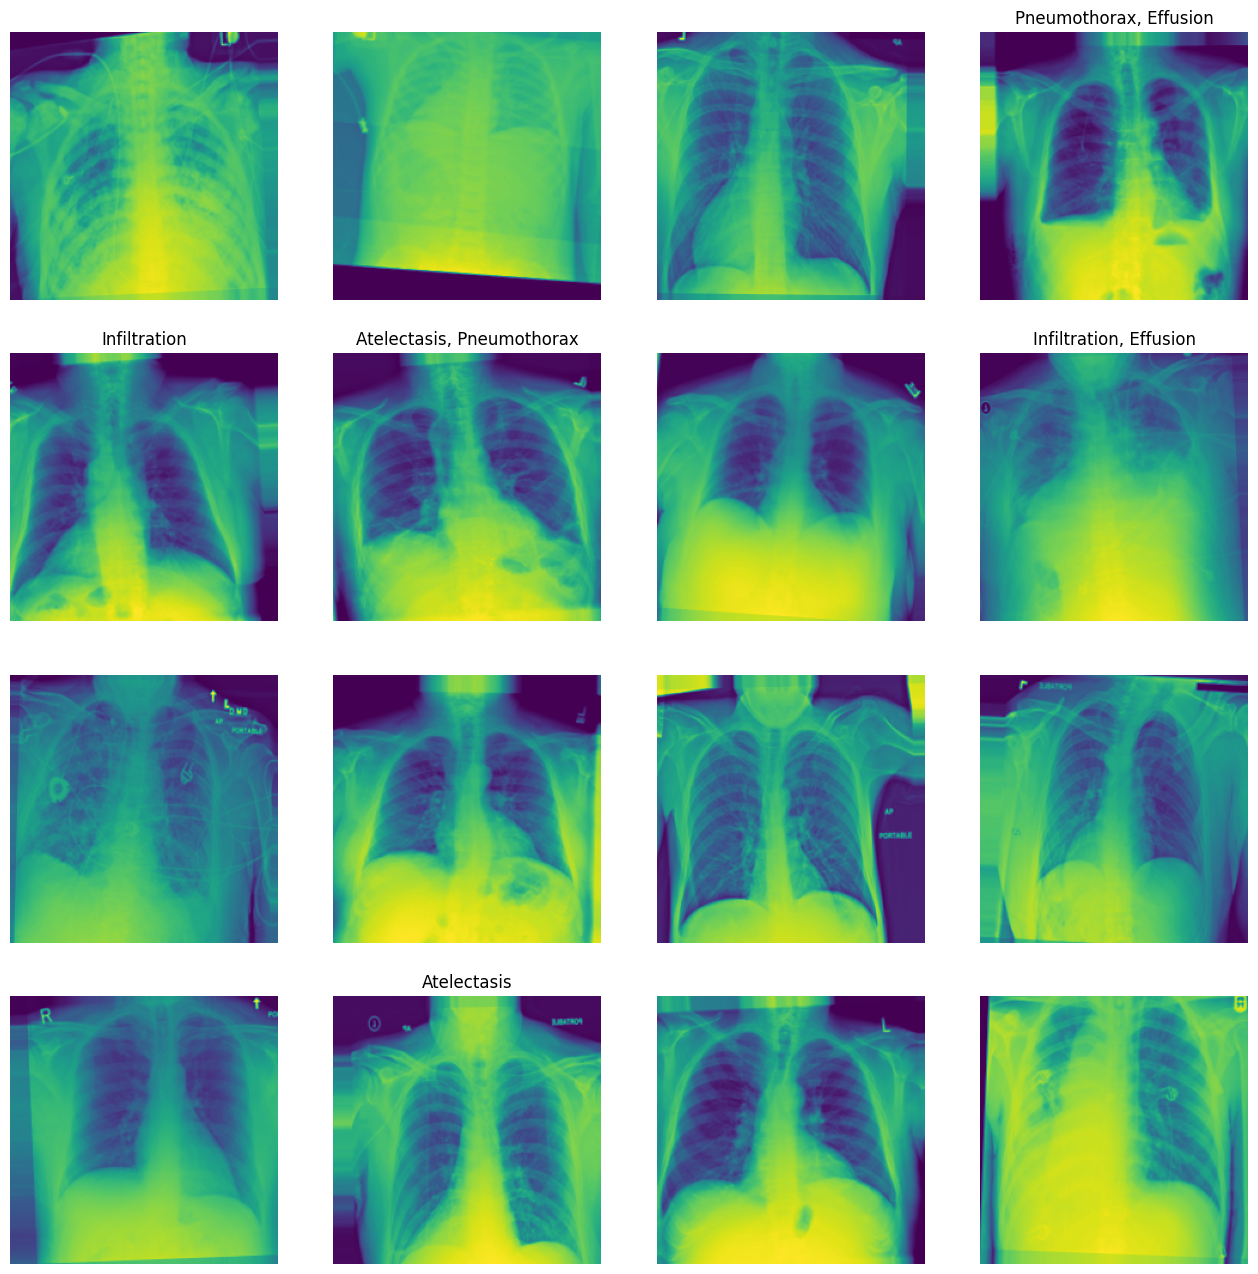

In [32]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [33]:
from keras.applications import DenseNet121
from keras.optimizers import Adamax

def build_model():
    # Load the pre-trained DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    # Add new trainable layers on top of the pre-trained model
    x = base_model.output

    preds = Dense(len(labels), activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=preds)
    # Create an Adam optimizer with weight decay
    optimizer = Adamax(learning_rate=1e-3)
    model.compile(optimizer=optimizer ,loss='binary_crossentropy',metrics=['binary_accuracy']) 
    return model
    #model.summary()

In [34]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [35]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()
#multi_gpu_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = 'model/DenseNet121.keras'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-7)
checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


In [37]:
# Train the model using the generator
history = multi_gpu_model.fit(
    train_generator,
    epochs=20,
    #steps_per_epoch=100,
    callbacks=[anne, checkpoint, early_stopping],

    validation_data=val_generator,
)

Epoch 1/20
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9429 - loss: 0.1797
Epoch 1: val_loss improved from inf to 0.18447, saving model to model/DenseNet121.keras
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1787s 1s/step - binary_accuracy: 0.9429 - loss: 0.1797 - val_binary_accuracy: 0.9388 - val_loss: 0.1845 - learning_rate: 0.0010
Epoch 2/20
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - binary_accuracy: 0.9486 - loss: 0.1582
Epoch 2: val_loss improved from 0.18447 to 0.15873, saving model to model/DenseNet121.keras
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1274s 1s/step - binary_accuracy: 0.9486 - loss: 0.1582 - val_binary_accuracy: 0.9494 - val_loss: 0.1587 - learning_rate: 0.0010
Epoch 3/20
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9495 - loss: 0.1534
Epoch 3: val_loss improved from 0.15873 to 0.15824, saving model to model/DenseNet121.keras
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1329s 1s/step - binary_accuracy: 0.9495 - loss: 0.1534 - val_binary_accuracy: 0.9475 - val_los

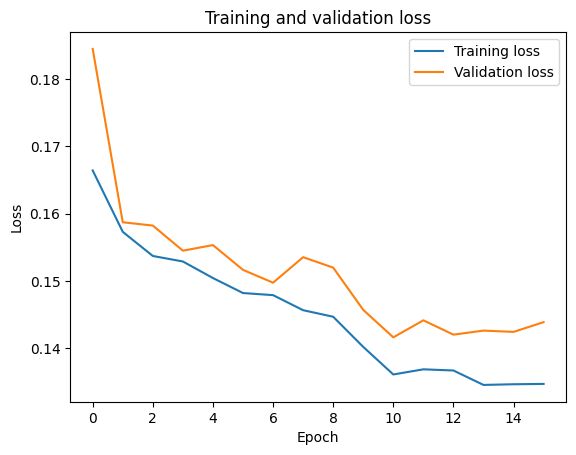

In [38]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
from keras.models import load_model
# Load the trained model
#multi_gpu_model=0
#multi_gpu_model = load_model('/kaggle/working/model/DenseNet121.keras')

In [40]:
test_generator=0

In [41]:
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=12022         
)

x_test, y_test = next(test_generator)

Found 23573 validated image filenames.


In [42]:
y_pred = multi_gpu_model.predict(x_test)

376/376 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step


In [43]:
# Get the true labels for the test data
#y_true = test_generator.labels
y_true= y_test
# Print the percentage of true and predicted diagnoses
for c_label, p_count, t_count in zip(labels, 
                                     100*np.mean(y_pred, 0), 
                                     100*np.mean(y_test, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: actual: 10.06%, predicted: 9.77%
Consolidation: actual: 4.11%, predicted: 3.82%
Infiltration: actual: 18.30%, predicted: 19.21%
Pneumothorax: actual: 4.66%, predicted: 4.58%
Edema: actual: 2.00%, predicted: 2.19%
Emphysema: actual: 2.22%, predicted: 2.15%
Fibrosis: actual: 1.46%, predicted: 1.24%
Effusion: actual: 12.37%, predicted: 12.69%
Pneumonia: actual: 1.21%, predicted: 1.18%
Pleural_Thickening: actual: 2.89%, predicted: 3.85%
Cardiomegaly: actual: 2.35%, predicted: 2.83%
Nodule: actual: 5.49%, predicted: 4.36%
Mass: actual: 4.97%, predicted: 4.25%
Hernia: actual: 0.16%, predicted: 0.20%


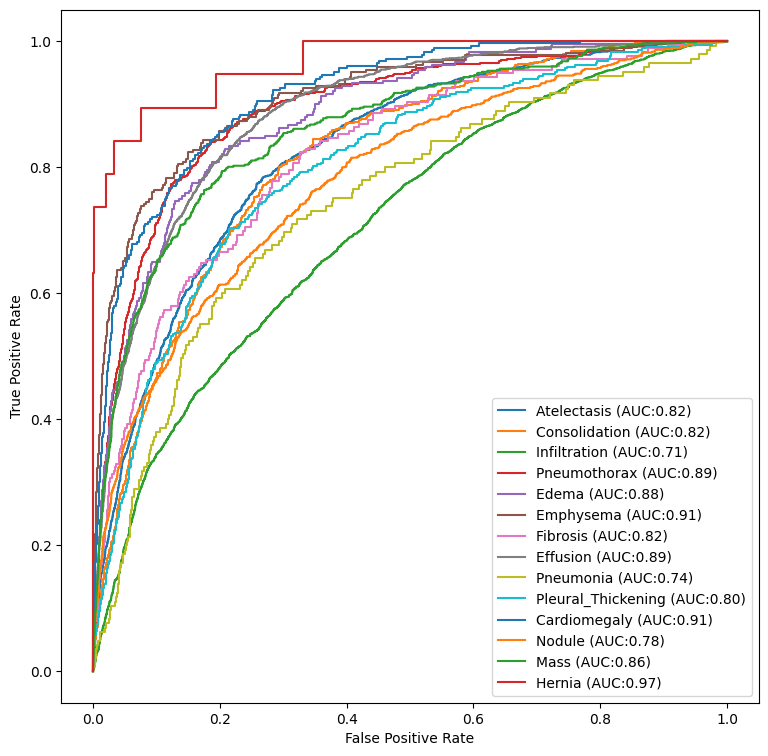

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_true[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('DenseNet121_p3.png')

In [45]:
roc_auc_score(y_true.astype(int), y_pred)
# 0.806

0.8435699731880287

In [46]:
from sklearn.metrics import multilabel_confusion_matrix
# Convert the predicted probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)

# Print the confusion matrix for each label
for i, label in enumerate(labels):
    print(f"Confusion matrix for {label}:")
    print(cm[i])

Confusion matrix for Atelectasis:
[[10661   151]
 [ 1017   193]]
Confusion matrix for Consolidation:
[[11527     1]
 [  494     0]]
Confusion matrix for Infiltration:
[[9507  315]
 [1913  287]]
Confusion matrix for Pneumothorax:
[[11355   107]
 [  458   102]]
Confusion matrix for Edema:
[[11773     9]
 [  233     7]]
Confusion matrix for Emphysema:
[[11700    55]
 [  204    63]]
Confusion matrix for Fibrosis:
[[11843     3]
 [  175     1]]
Confusion matrix for Effusion:
[[10162   373]
 [  855   632]]
Confusion matrix for Pneumonia:
[[11877     0]
 [  145     0]]
Confusion matrix for Pleural_Thickening:
[[11641    33]
 [  331    17]]
Confusion matrix for Cardiomegaly:
[[11673    66]
 [  226    57]]
Confusion matrix for Nodule:
[[11324    38]
 [  613    47]]
Confusion matrix for Mass:
[[11321   104]
 [  488   109]]
Confusion matrix for Hernia:
[[11998     5]
 [   11     8]]


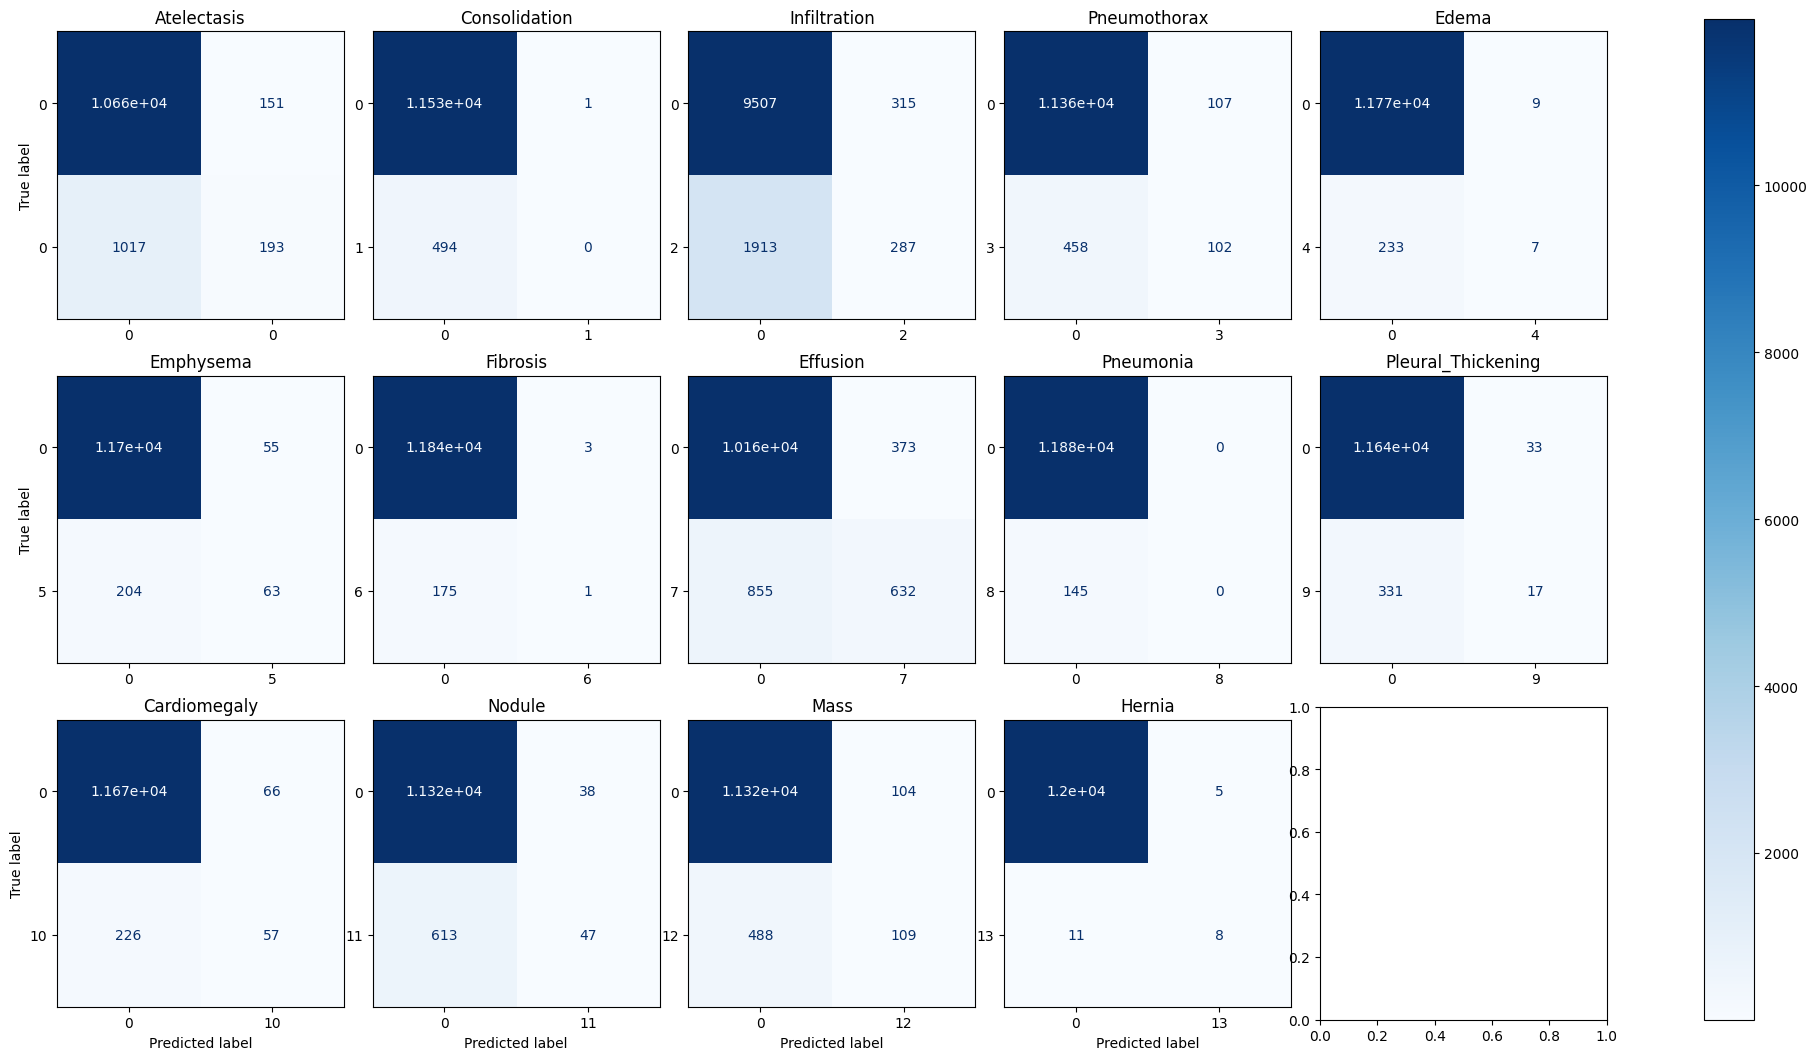

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
f, axes = plt.subplots(3, 5, figsize=(25, 13))
axes = axes.ravel()

# Loop through each class label
for i in range(len(labels)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, i])
    # Set the color map to 'Blues'
    disp.plot(ax=axes[i], values_format='.4g', cmap='Blues')
    disp.ax_.set_title(labels[i])
    if i < 10:
        disp.ax_.set_xlabel('')
    if i % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

# Adjust the spacing between the subplots and show the color bar
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)

# Show the plot
plt.show()

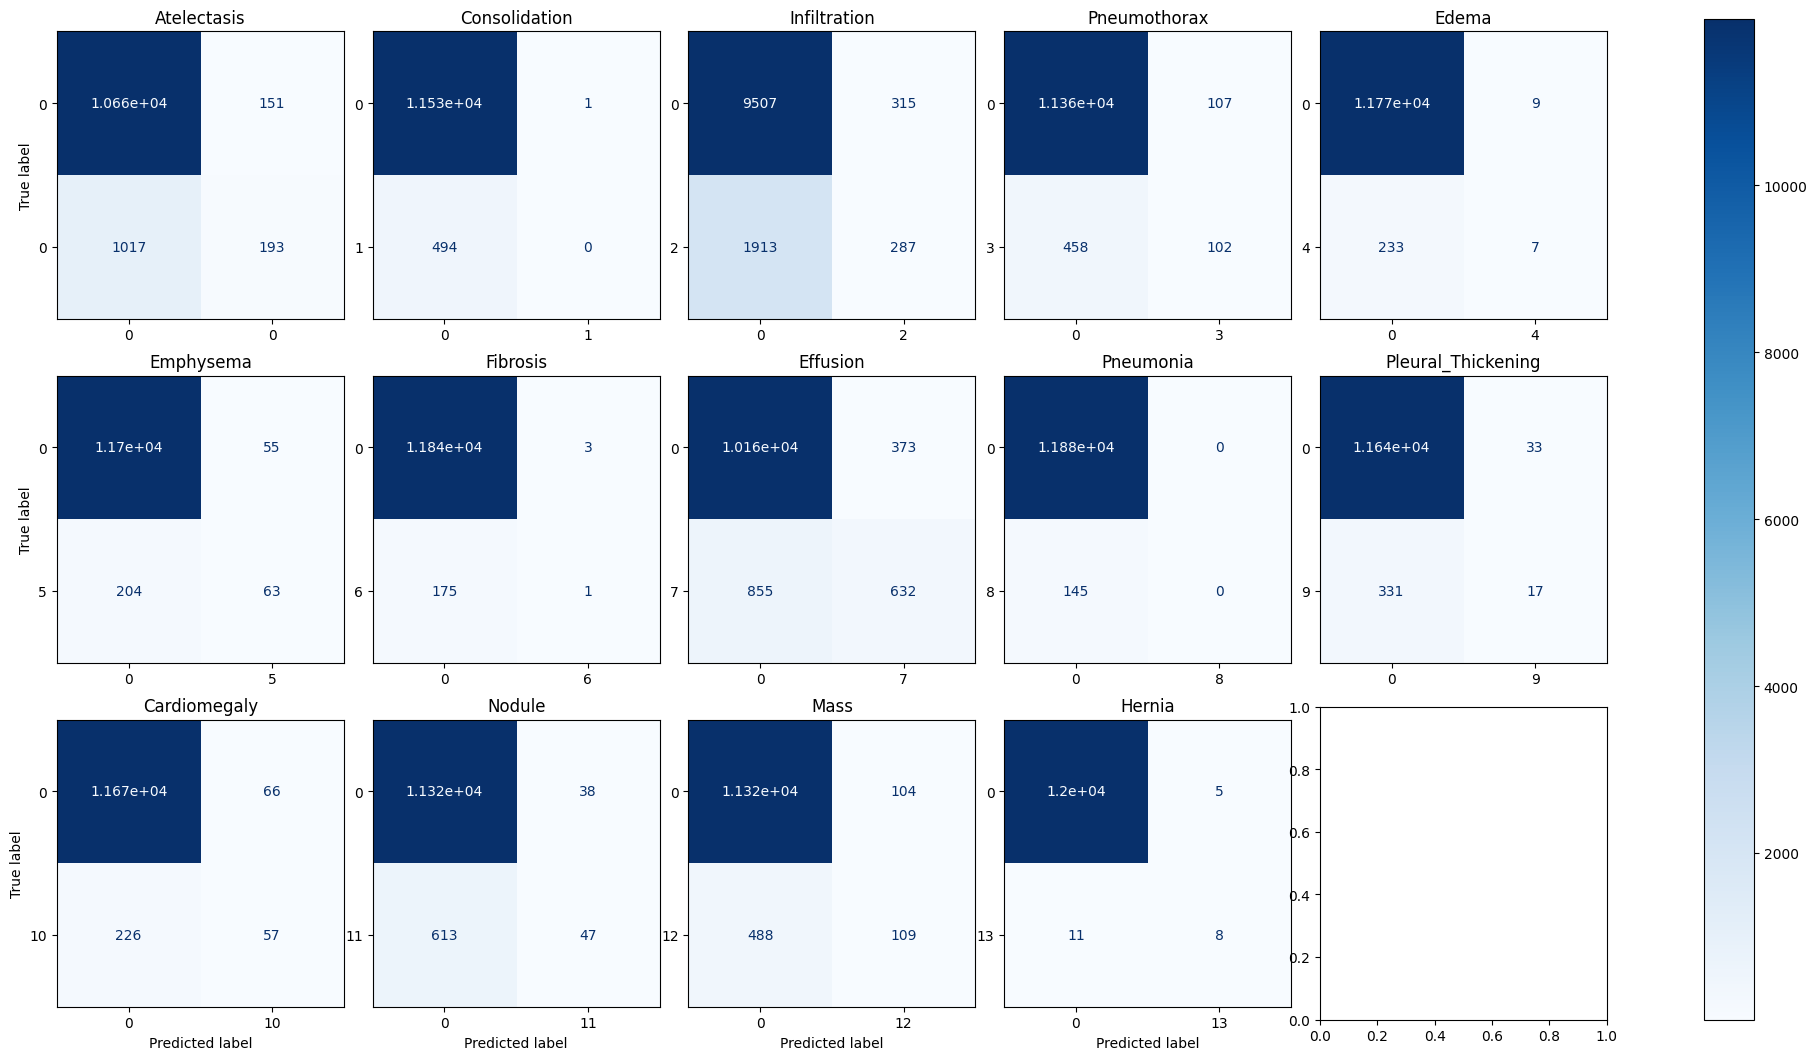

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
f, axes = plt.subplots(3, 5, figsize=(25, 13))
axes = axes.ravel()

# Loop through each class label
for i in range(len(labels)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, i])
    # Set the color map to 'Blues'
    disp.plot(ax=axes[i], values_format='.4g', cmap='Blues')
    disp.ax_.set_title(labels[i])
    if i < 10:
        disp.ax_.set_xlabel('')
    if i % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

# Adjust the spacing between the subplots and show the color bar
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)

# Show the plot
plt.show()

In [54]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Smaller batch size to fit within memory constraints
batch_size = 512

# Adjust the test generator with the new batch size
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False  # Ensure data order is consistent
)

# Initialize arrays to store predictions and true labels
y_preds = []
y_trues = []

# Iterate over the test generator and collect predictions
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = multi_gpu_model.predict(x_batch)
    y_preds.append(y_pred_batch)
    y_trues.append(y_batch)

# Concatenate all batches together
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

# Extract class labels from the dataframe columns
class_labels = test_df[labels].columns

# Compute the ROC AUC score for each class
roc_auc_scores = {}
for i, label in enumerate(class_labels):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")


Found 23573 validated image filenames.
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
1

Micro-Average ROC AUC Score: 0.8878


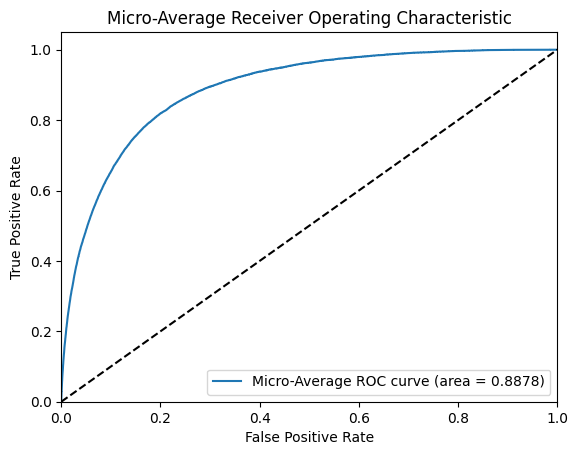

In [55]:
# Compute the ROC AUC score (micro-average)
roc_auc_micro = roc_auc_score(y_trues, y_preds, average='micro')
print(f"Micro-Average ROC AUC Score: {roc_auc_micro:.4f}")

# Compute the ROC curve (micro-average)
fpr, tpr, _ = roc_curve(y_trues.ravel(), y_preds.ravel())

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Micro-Average ROC curve (area = {roc_auc_micro:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

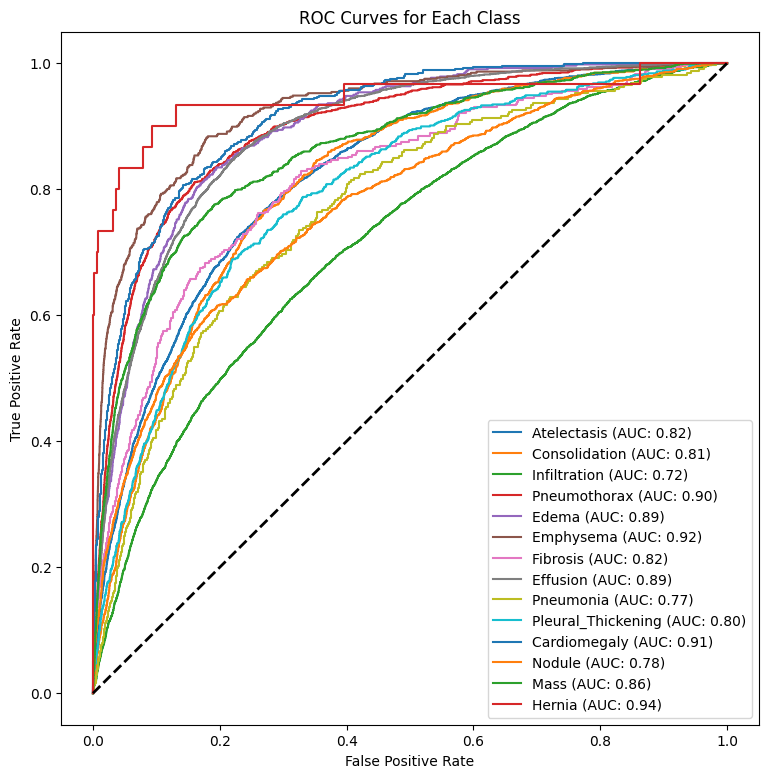

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_trues and y_preds are already defined
# class_labels should be a list of class names

# Plot ROC curves for each class
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(class_labels):
    fpr, tpr, thresholds = roc_curve(y_trues[:, idx], y_preds[:, idx])
    auc_score = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')

# Plotting the diagonal line
c_ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curves for Each Class')
c_ax.legend(loc='best')

# Save the figure
fig.savefig('DenseNet121_p3.png')
plt.show()
